In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# !pip install kneed
from kneed import KneeLocator

import warnings
warnings.filterwarnings('ignore')
sns.set()

In [2]:
# Import data
df = pd.read_csv('segmentation data.csv', index_col = 0)
df.head()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
ID,,,,,,,
100000001,0,0,67,2,124670,1,2
100000002,1,1,22,1,150773,1,2
100000003,0,0,49,1,89210,0,0
100000004,0,0,45,1,171565,1,1
100000005,0,0,53,1,149031,1,1


In [3]:
df.describe()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
count,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000
mean,0.457000,0.496500,35.909000,1.03800,120954.419000,0.810500,0.739000
std,0.498272,0.500113,11.719402,0.59978,38108.824679,0.638587,0.812533
min,0.000000,0.000000,18.000000,0.00000,35832.000000,0.000000,0.000000
25%,0.000000,0.000000,27.000000,1.00000,97663.250000,0.000000,0.000000
50%,0.000000,0.000000,33.000000,1.00000,115548.500000,1.000000,1.000000
75%,1.000000,1.000000,42.000000,1.00000,138072.250000,1.000000,1.000000
max,1.000000,1.000000,76.000000,3.00000,309364.000000,2.000000,2.000000


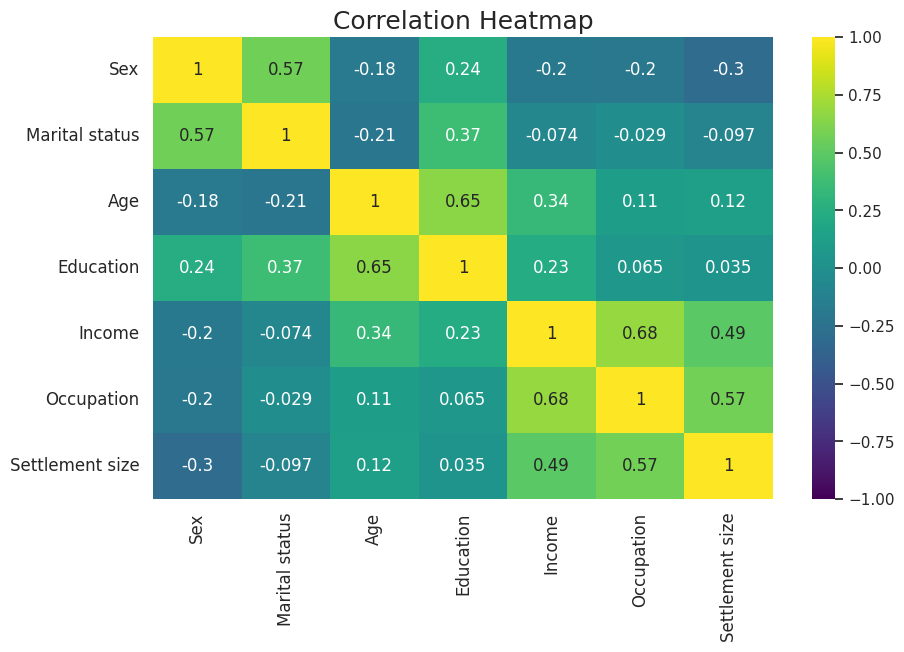

In [4]:
# Correlation Estimate in Heatmap

plt.figure(figsize=(10,6))
s = sns.heatmap(df.corr(), annot = True, cmap = 'viridis', vmin = -1, vmax=1)
# different color sets = 'viridis', 'autumn', 'rainbow'
s.set_yticklabels(s.get_yticklabels(), rotation = 0, fontsize =12)
s.set_xticklabels(s.get_xticklabels(), rotation = 90, fontsize =12)
plt.title('Correlation Heatmap', fontsize =18)
plt.show()

K-means++

In [5]:
# ---------------------------------------------------------
# 1. Load the data
# ---------------------------------------------------------
df_kmeans = df.copy(deep = True)
print("Data Snapshot:")
print(df_kmeans.head())

Data Snapshot:
           Sex  Marital status  Age  Education  Income  Occupation  \
ID                                                                   
100000001    0               0   67          2  124670           1   
100000002    1               1   22          1  150773           1   
100000003    0               0   49          1   89210           0   
100000004    0               0   45          1  171565           1   
100000005    0               0   53          1  149031           1   

           Settlement size  
ID                          
100000001                2  
100000002                2  
100000003                0  
100000004                1  
100000005                1  


### Standardization  
Clustering, particularly k-means clustering, is highly sensitive to the scale of feature values. To ensure comparability, all features should be transformed to fall within the same numerical range. This process, known as standardization, allows differences between values to be meaningful. Therefore, before applying clustering, I scaled the data accordingly.

In [6]:
# ---------------------------------------------------------
# 2. Scale the data
# ---------------------------------------------------------
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_kmeans)

The optimal number of clusters suggested by the Elbow criterion: 5


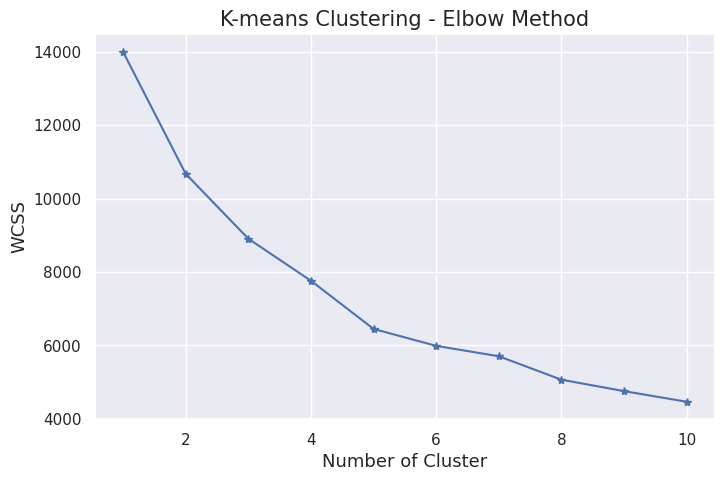

In [7]:
# Finding and plotting the Within Cluster Sum of Squares for the different number of clusters.

wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(data_scaled)
    wcss.append(kmeans.inertia_)


# Elbow method
plt.figure(figsize =(8,5))
# Changed this line to plot wcss against the range of cluster numbers
plt.plot(range(1, 11), wcss,  marker = '*', linestyle = '-' )

plt.xlabel('Number of Cluster', fontsize = 13)
plt.ylabel('WCSS', fontsize = 13)
plt.title('K-means Clustering - Elbow Method', fontsize = 15)

# Extract x and y values from WCSS
x, y = range(1, 11), wcss

# Identify the optimal number of clusters using the Elbow method
kn = KneeLocator(x, y, curve="convex", direction="decreasing")

print(f"The optimal number of clusters suggested by the Elbow criterion: {kn.knee}")

In [8]:
kmeans =KMeans(n_clusters =5, max_iter = 500,  init = 'k-means++', random_state= 42)
kmeans.fit(data_scaled)

KMeans(max_iter=500, n_clusters=5, random_state=42)

In [9]:
df_kmeans['Segment_KMeans'] = kmeans.labels_
df_kmeans['Segment_KMeans'].replace({0: "A", 1: "B", 2: "C", 3:"D", 4: "E"}, inplace=True)

In [10]:
df_segm_analysis = df_kmeans.groupby(['Segment_KMeans']).mean()
df_segm_analysis

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
Segment_KMeans,,,,,,,
A,0.028302,0.000000,35.418239,0.619497,100066.210692,0.393082,0.110063
B,0.891705,0.652074,33.297235,1.108295,89360.076037,0.094470,0.000000
C,0.748582,0.979206,27.924386,1.003781,119900.778828,1.052930,0.814745
D,0.004264,0.044776,37.142857,0.710021,144048.624733,1.283582,1.539446
E,0.480000,0.684000,55.648000,2.136000,161276.772000,1.184000,1.160000


In [11]:
# Compute the size and proportions of the four clusters
df_segm_analysis['N_Obs'] = df_kmeans[['Segment_KMeans', 'Sex']].groupby(['Segment_KMeans'])['Sex'].count()
df_segm_analysis['Prop_Obs'] = df_segm_analysis.N_Obs / df_segm_analysis.N_Obs.sum()
df_segm_analysis

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,N_Obs,Prop_Obs
Segment_KMeans,,,,,,,,,
A,0.028302,0.000000,35.418239,0.619497,100066.210692,0.393082,0.110063,318,0.1590
B,0.891705,0.652074,33.297235,1.108295,89360.076037,0.094470,0.000000,434,0.2170
C,0.748582,0.979206,27.924386,1.003781,119900.778828,1.052930,0.814745,529,0.2645
D,0.004264,0.044776,37.142857,0.710021,144048.624733,1.283582,1.539446,469,0.2345
E,0.480000,0.684000,55.648000,2.136000,161276.772000,1.184000,1.160000,250,0.1250


### Qualitative Analysis of the Clusters

The clusters generated by KMeans segmentation show distinct patterns across various features. Here's a breakdown of each segment:

#### **Segment A**
- **Sex**: Low value (0.03), indicating mostly females in this segment.
- **Marital Status**: 0.00, suggesting that most individuals in this cluster may be single or not classified by marital status.
- **Age**: Average age of 35.42 years, placing this segment in the mid-adult age group.
- **Education**: Moderate education level (0.62), indicating some individuals have a higher education.
- **Income**: Average income of ₹100,066, indicating a middle-income group.
- **Occupation**: Occupation score of 0.39, suggesting moderate engagement in professional roles.
- **Settlement Size**: Low settlement size (0.11), likely indicating individuals in smaller urban areas or rural settings.

#### **Segment B**
- **Sex**: Very high value (0.89), indicating a predominantly male group.
- **Marital Status**: 0.65, showing that a significant portion of this segment is married.
- **Age**: Average age of 33.3 years, similar to Segment A, within the young adult range.
- **Education**: Higher education level (1.11), likely a more educated segment.
- **Income**: ₹89,360, indicating a slightly lower average income compared to other segments.
- **Occupation**: Low occupation score (0.09), suggesting individuals in less specialized or lower-skilled roles.
- **Settlement Size**: 0.00, indicating individuals are located in smaller towns or rural areas.

#### **Segment C**
- **Sex**: High value (0.75), indicating a predominantly male group.
- **Marital Status**: Very high value (0.98), suggesting most individuals are married.
- **Age**: Average age of 27.92 years, representing younger adults.
- **Education**: Education level is moderate (1.00), indicating a reasonably well-educated segment.
- **Income**: High income of ₹119,900, suggesting this cluster consists of higher-income individuals.
- **Occupation**: High occupation score (1.05), indicating a significant portion of the group is employed in high-skill or professional jobs.
- **Settlement Size**: Relatively large settlement size (0.81), pointing to individuals in urban settings.

#### **Segment D**
- **Sex**: Very low value (0.004), likely representing a predominantly female group.
- **Marital Status**: Very low value (0.04), suggesting a low number of married individuals in this group.
- **Age**: Higher average age of 37.14 years, indicating older adults.
- **Education**: Moderate education level (0.71), with a mix of education levels.
- **Income**: Higher income of ₹144,048, indicating a wealthier demographic.
- **Occupation**: High occupation score (1.28), likely a highly professional or specialized group.
- **Settlement Size**: Very high settlement size (1.54), suggesting individuals are concentrated in larger cities or metropolitan areas.

#### **Segment E**
- **Sex**: Moderate value (0.48), indicating a fairly balanced distribution between sexes.
- **Marital Status**: High value (0.68), with a significant portion of the group being married.
- **Age**: High average age of 55.65 years, representing older adults.
- **Education**: High education score (2.14), indicating a well-educated segment.
- **Income**: High income of ₹161,276, suggesting a wealthy demographic.
- **Occupation**: High occupation score (1.18), indicating this segment consists of individuals with specialized or senior professional roles.
- **Settlement Size**: Moderate settlement size (1.16), likely indicating urban or suburban settings.

### Summary
- **Segment A** appears to represent a middle-income, moderately educated group with a lower settlement size.
- **Segment B** represents younger, less educated individuals with lower incomes and a rural/less urbanized setting.
- **Segment C** is a younger, more affluent, and highly professional group located in urban areas.
- **Segment D** consists of older, highly educated professionals with high incomes and residing in large cities.
- **Segment E** represents older, highly educated, and affluent individuals in urban or suburban areas, likely in senior roles.

These clusters reflect differences in age, income, education, occupation, marital status, sex, and settlement size, which could be useful for targeted marketing or segmentation analysis.

In [12]:
df_segm_analysis.rename({'A':'Mid-income single females', 'B': 'Low-income rural males',
                         'C': 'Mid-income urban married', 'D': 'High income single urban females', 'E': 'Senior well-offs' }, inplace =True)

In [13]:
df_kmeans['Labels']  = df_kmeans['Segment_KMeans'].map({'A':'Mid-income single females', 'B': 'Low-income rural males',
                         'C': 'Mid-income urban married', 'D': 'High income single urban females', 'E': 'Senior well-offs' })

In [14]:
df_kmeans.head()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Segment_KMeans,Labels
ID,,,,,,,,,
100000001,0,0,67,2,124670,1,2,E,Senior well-offs
100000002,1,1,22,1,150773,1,2,C,Mid-income urban married
100000003,0,0,49,1,89210,0,0,A,Mid-income single females
100000004,0,0,45,1,171565,1,1,D,High income single urban females
100000005,0,0,53,1,149031,1,1,D,High income single urban females


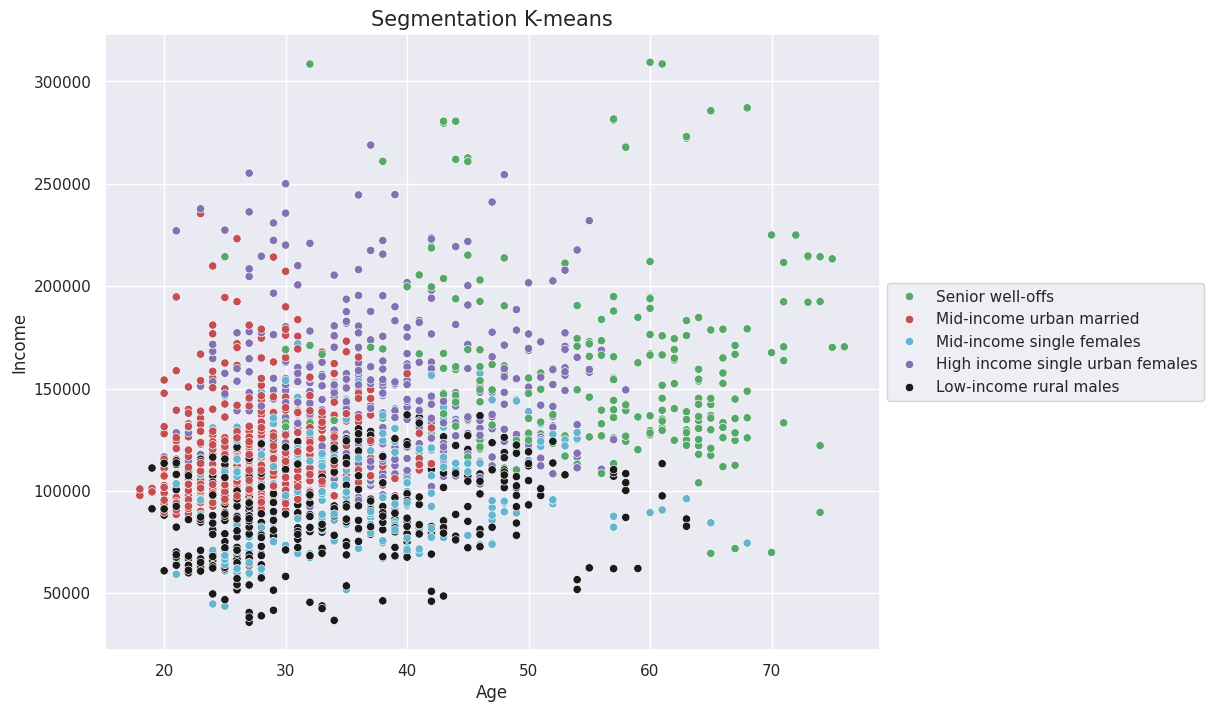

In [15]:
x_axis = df_kmeans['Age']
y_axis = df_kmeans['Income']
plt.figure(figsize = (10,8))
# Specify x and y using keyword arguments
sns.scatterplot(x=x_axis, y=y_axis, hue = df_kmeans.Labels, palette = ['g', 'r', 'c', 'm', 'k'])
plt.title('Segmentation K-means',fontsize = 15)
plt.legend( bbox_to_anchor = (1, 0.5), loc = 6)
plt.show()

## PCA

In [16]:
pca = PCA()
pca.fit(data_scaled)

PCA()

In [17]:
# Explained variance proportion of each component.
pca.explained_variance_ratio_

array([0.35696328, 0.26250923, 0.18821114, 0.0755775 , 0.05716512,
       0.03954794, 0.02002579])

Text(0, 0.5, 'Cumulative Explained Variance')

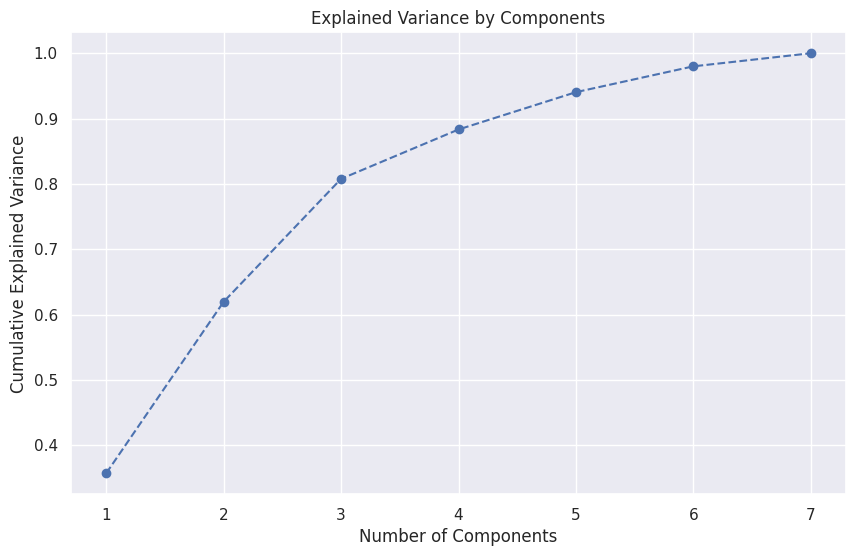

In [18]:
# Plot the cumulative variance explained by total number of components.
# On this graph we choose the subset of components we want to keep

plt.figure(figsize = (10,6))
plt.plot(range(1,8), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

In [19]:
# We choose 3 components since it explains 80% of variance

pca= PCA(n_components =3)
pca.fit(data_scaled)

PCA(n_components=3)

In [20]:
# The components attribute shows the loadings of each component on each of the seven original features.
# The loadings are the correlations between the components and the original features.

pca.components_

array([[-0.31469524, -0.19170439,  0.32609979,  0.15684089,  0.52452463,
         0.49205868,  0.46478852],
       [ 0.45800608,  0.51263492,  0.31220793,  0.63980683,  0.12468314,
         0.01465779, -0.06963165],
       [-0.29301261, -0.44197739,  0.60954372,  0.27560461, -0.16566231,
        -0.39550539, -0.29568503]])

In [20]:
df_pca_comp = pd.DataFrame(data = pca.components_,
                           columns = df.columns.values,
                           index = ['Component 1', 'Component 2', 'Component 3'])
df_pca_comp

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
Component 1,-0.314695,-0.191704,0.326100,0.156841,0.524525,0.492059,0.464789
Component 2,0.458006,0.512635,0.312208,0.639807,0.124683,0.014658,-0.069632
Component 3,-0.293013,-0.441977,0.609544,0.275605,-0.165662,-0.395505,-0.295685


Text(0.5, 1.0, 'Loadings')

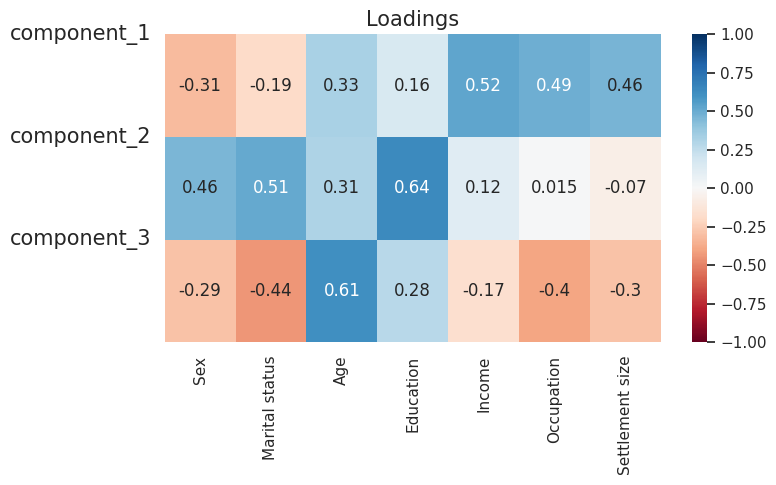

In [21]:
plt.figure(figsize=(8,4))
sns.heatmap(df_pca_comp, vmin = -1, vmax = 1, cmap = 'RdBu', annot = True)
plt.yticks([0,1,2], ['component_1', 'component_2', 'component_3'],rotation = 0, fontsize = 15 )
plt.title('Loadings',  fontsize = 15 )

- **Component 1**: Positively correlated with age, income, occupation, and settlement size, indicating a career-focused component.
- **Component 2**: Dominated by sex, marital status, and education, unrelated to career features, reflecting education and lifestyle rather than career.
- **Component 3**: Driven by age, marital status, and occupation, with negative correlations suggesting this component represents an experienced individual, regardless of career or life experience.

The original 7-dimensional data should be reduced to 3 dimensions based on these insights.

In [22]:
scores_pca = pca.transform(data_scaled)
scores_pca

array([[ 2.51474593,  0.83412239,  2.1748059 ],
       [ 0.34493528,  0.59814564, -2.21160279],
       [-0.65106267, -0.68009318,  2.2804186 ],
       ...,
       [-1.45229829, -2.23593665,  0.89657125],
       [-2.24145254,  0.62710847, -0.53045631],
       [-1.86688505, -2.45467234,  0.66262172]])

The optimal number of clusters suggested by the Elbow criterion: 4


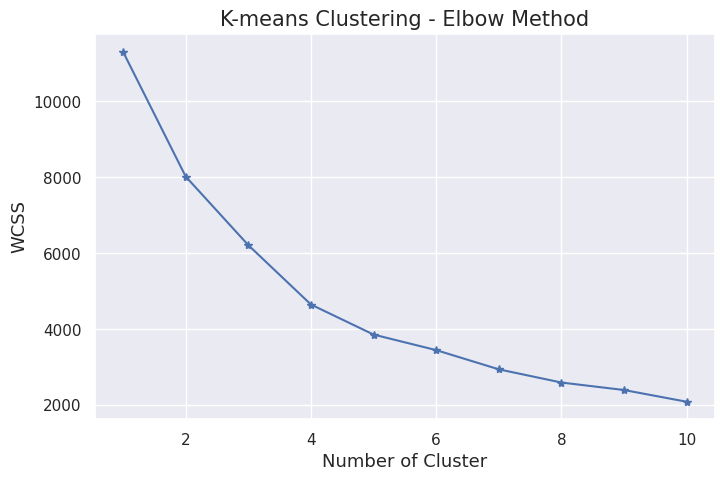

In [23]:
wcss = []
for i in range(1,11):
    kmeans_pca = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans_pca.fit(scores_pca)
    wcss.append(kmeans_pca.inertia_)


# Elbow method
plt.figure(figsize =(8,5))
# Changed this line to plot wcss against the range of cluster numbers
plt.plot(range(1, 11), wcss,  marker = '*', linestyle = '-' )

plt.xlabel('Number of Cluster', fontsize = 13)
plt.ylabel('WCSS', fontsize = 13)
plt.title('K-means Clustering - Elbow Method', fontsize = 15)

# Extract x and y values from WCSS
x, y = range(1, 11), wcss

# Identify the optimal number of clusters using the Elbow method
kn = KneeLocator(x, y, curve="convex", direction="decreasing")

print(f"The optimal number of clusters suggested by the Elbow criterion: {kn.knee}")

In [24]:
# We will take 4 again based on elbow method

kmeans_pca = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
kmeans_pca.fit(scores_pca)

KMeans(n_clusters=4, random_state=42)

In [25]:
# We create a new data frame with the original features and add the PCA scores and assigned clusters.

df_segm_pca_kmeans = pd.concat([df.reset_index(drop = True), pd.DataFrame(scores_pca)], axis = 1)
df_segm_pca_kmeans.columns.values[-3: ] = ['Component 1', 'Component 2', 'Component 3']

# The last column we add contains the pca k-means clustering labels.

df_segm_pca_kmeans['Segment K-means PCA'] = kmeans_pca.labels_

In [27]:
df_segm_pca_kmeans

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Component 1,Component 2,Component 3,Segment K-means PCA
0,0,0,67,2,124670,1,2,2.514746,0.834122,2.174806,3
1,1,1,22,1,150773,1,2,0.344935,0.598146,-2.211603,2
2,0,0,49,1,89210,0,0,-0.651063,-0.680093,2.280419,1
3,0,0,45,1,171565,1,1,1.714316,-0.579927,0.730731,0
4,0,0,53,1,149031,1,1,1.626745,-0.440496,1.244909,0
...,...,...,...,...,...,...,...,...,...,...,...
1995,1,0,47,1,123525,0,0,-0.866034,0.298330,1.438958,1
1996,1,1,27,1,117744,1,0,-1.114957,0.794727,-1.079871,2
1997,0,0,31,0,86400,0,0,-1.452298,-2.235937,0.896571,1
1998,1,1,24,1,97968,0,0,-2.241453,0.627108,-0.530456,1


In [26]:
# We calculate the means by segments.

df_segm_pca_kmeans_freq = df_segm_pca_kmeans.groupby(['Segment K-means PCA']).mean()
df_segm_pca_kmeans_freq

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Component 1,Component 2,Component 3
Segment K-means PCA,,,,,,,,,,
0,0.001661,0.041528,36.674419,0.684385,138482.186047,1.200997,1.255814,1.228891,-1.220013,0.041063
1,0.627869,0.454098,33.473770,0.944262,88824.154098,0.078689,0.009836,-1.607567,-0.110732,0.625678
2,0.762357,0.973384,27.889734,1.007605,119503.418251,1.055133,0.813688,-0.395592,0.518043,-1.204763
3,0.492366,0.683206,55.919847,2.129771,158400.877863,1.125954,1.099237,1.713376,2.021006,0.867641


### Segment Summary

- **Segment 0**: This group consists of career-focused individuals in their mid-30s, with a high income (₹138,482), moderate education (0.68), and professional occupations. They are likely to reside in urban areas, with a more settled lifestyle and moderate life experience.

- **Segment 1**: Predominantly younger individuals (around 33 years) in rural or smaller settlements, earning lower incomes (₹88,824). They have some education but are still early in their career paths, likely in entry-level or lower-skilled jobs, and less focused on career development.

- **Segment 2**: This segment includes young, affluent individuals (age: 27.9), with higher education and high incomes (₹119,503). They are likely to be professionals in urban areas, focused on their education and lifestyle, rather than their career or work experience.

- **Segment 3**: Comprising older, highly educated, and affluent individuals (average age of 55.92), this group reflects significant career and life experience. They are likely to be in senior professional roles, living in urban or suburban areas, and balancing their education, career, and lifestyle.

In [27]:
# Calculate the size of each cluster and its proportion to the entire data set.

df_segm_pca_kmeans_freq['N_Obs'] = df_segm_pca_kmeans[['Segment K-means PCA','Sex']].groupby(['Segment K-means PCA']).count()
df_segm_pca_kmeans_freq['Prop_Obs'] = df_segm_pca_kmeans_freq['N_Obs'] / df_segm_pca_kmeans_freq['N_Obs'].sum()
df_segm_pca_kmeans_freq = df_segm_pca_kmeans_freq.rename({0:'High income single urban females',
                                                          1:'Low-income rural males',
                                                          2:'Mid-income urban married',
                                                          3:'Senior well-offs'})
df_segm_pca_kmeans_freq

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Component 1,Component 2,Component 3,N_Obs,Prop_Obs
Segment K-means PCA,,,,,,,,,,,,
High income single urban females,0.001661,0.041528,36.674419,0.684385,138482.186047,1.200997,1.255814,1.228891,-1.220013,0.041063,602,0.301
Low-income rural males,0.627869,0.454098,33.473770,0.944262,88824.154098,0.078689,0.009836,-1.607567,-0.110732,0.625678,610,0.305
Mid-income urban married,0.762357,0.973384,27.889734,1.007605,119503.418251,1.055133,0.813688,-0.395592,0.518043,-1.204763,526,0.263
Senior well-offs,0.492366,0.683206,55.919847,2.129771,158400.877863,1.125954,1.099237,1.713376,2.021006,0.867641,262,0.131


In [28]:
df_segm_pca_kmeans['Legend'] = df_segm_pca_kmeans['Segment K-means PCA'].map({0:'High income single urban females',
                                                          1:'Low-income rural males',
                                                          2:'Mid-income urban married',
                                                          3:'Senior well-offs'})

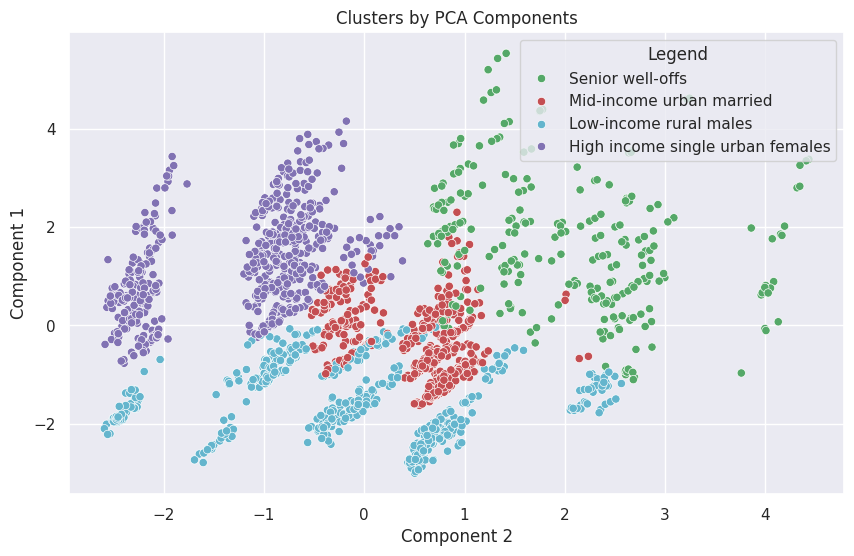

In [29]:
# Plot data by PCA components. For the first one, the Y axis is component 1, X axis is component 2.

x_axis = df_segm_pca_kmeans['Component 2']
y_axis = df_segm_pca_kmeans['Component 1']
plt.figure(figsize = (10, 6))
sns.scatterplot(x=x_axis, y=y_axis, hue = df_segm_pca_kmeans['Legend'], palette = ['g', 'r', 'c', 'm'])
plt.title('Clusters by PCA Components')
plt.show()

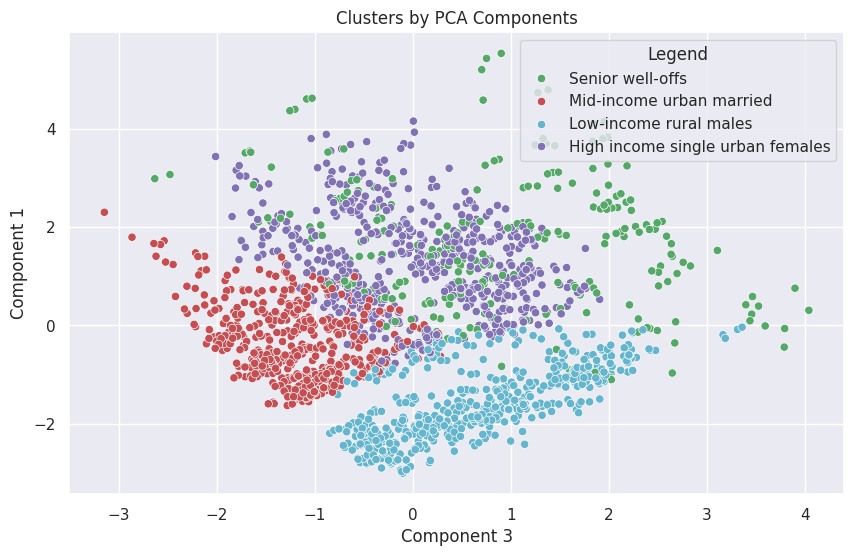

In [30]:
x_axis_1 = df_segm_pca_kmeans['Component 3']
y_axis_1 = df_segm_pca_kmeans['Component 1']
plt.figure(figsize = (10,6))
sns.scatterplot(x=x_axis_1, y=y_axis_1, hue = df_segm_pca_kmeans['Legend'], palette = ['g', 'r', 'c', 'm'])
plt.title('Clusters by PCA Components' )
plt.show()

Kernel PCA

In [31]:
from sklearn.decomposition import KernelPCA

# Apply Kernel PCA with a specific kernel (e.g., 'rbf')
kpca = KernelPCA(n_components=3, kernel='rbf')
scores_kpca = kpca.fit_transform(data_scaled)


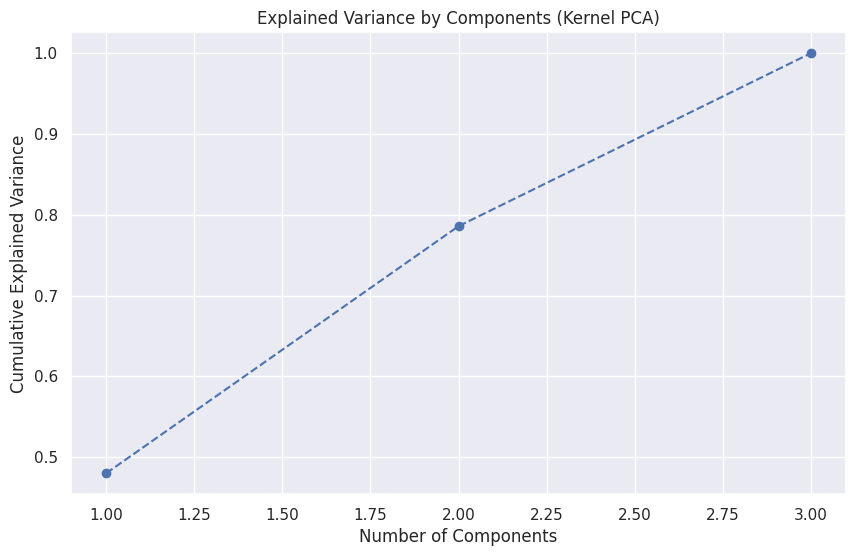

In [46]:
# Get the eigenvalues from the KernelPCA object
eigenvalues = kpca.eigenvalues_

# Calculate the explained variance ratio for each component
explained_variance_ratio = eigenvalues / np.sum(eigenvalues)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio.cumsum(), marker='o', linestyle='--')
plt.title('Explained Variance by Components (Kernel PCA)')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

The optimal number of clusters suggested by the Elbow criterion: 4


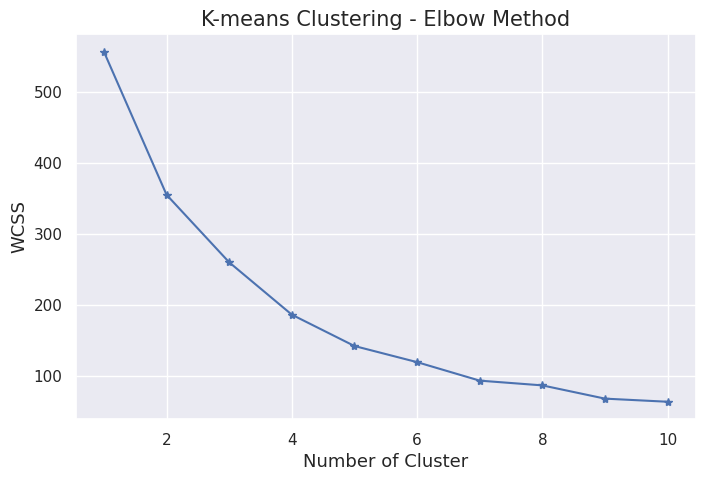

In [32]:
wcss = []
for i in range(1,11):
    kmeans_kpca = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans_kpca.fit(scores_kpca)
    wcss.append(kmeans_kpca.inertia_)


# Elbow method
plt.figure(figsize =(8,5))
# Changed this line to plot wcss against the range of cluster numbers
plt.plot(range(1, 11), wcss,  marker = '*', linestyle = '-' )

plt.xlabel('Number of Cluster', fontsize = 13)
plt.ylabel('WCSS', fontsize = 13)
plt.title('K-means Clustering - Elbow Method', fontsize = 15)

# Extract x and y values from WCSS
x, y = range(1, 11), wcss

# Identify the optimal number of clusters using the Elbow method
kn = KneeLocator(x, y, curve="convex", direction="decreasing")

print(f"The optimal number of clusters suggested by the Elbow criterion: {kn.knee}")

In [33]:
kmeans_kpca = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
kmeans_kpca.fit(scores_kpca)

KMeans(n_clusters=4, random_state=42)

In [34]:
# We create a new data frame with the original features and add the PCA scores and assigned clusters.

df_segm_kpca_kmeans = pd.concat([df.reset_index(drop = True), pd.DataFrame(scores_kpca)], axis = 1)
df_segm_kpca_kmeans.columns.values[-3: ] = ['Component 1', 'Component 2', 'Component 3']

# The last column we add contains the pca k-means clustering labels.

df_segm_kpca_kmeans['Segment K-means PCA'] = kmeans_kpca.labels_

In [35]:
df_segm_kpca_kmeans

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Component 1,Component 2,Component 3,Segment K-means PCA
0,0,0,67,2,124670,1,2,-0.276339,-0.087814,0.453695,2
1,1,1,22,1,150773,1,2,0.165349,-0.475544,-0.084416,1
2,0,0,49,1,89210,0,0,-0.217435,0.537210,0.121082,3
3,0,0,45,1,171565,1,1,-0.511227,-0.127051,0.095576,0
4,0,0,53,1,149031,1,1,-0.509610,-0.056842,0.192683,0
...,...,...,...,...,...,...,...,...,...,...,...
1995,1,0,47,1,123525,0,0,0.041745,0.371102,0.225238,3
1996,1,1,27,1,117744,1,0,0.586790,-0.165525,-0.160045,1
1997,0,0,31,0,86400,0,0,-0.179490,0.533762,-0.258377,3
1998,1,1,24,1,97968,0,0,0.594832,0.190638,-0.007024,3


In [36]:
# We calculate the means by segments.

df_segm_kpca_kmeans_freq = df_segm_kpca_kmeans.groupby(['Segment K-means PCA']).mean()
df_segm_kpca_kmeans_freq

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Component 1,Component 2,Component 3
Segment K-means PCA,,,,,,,,,,
0,0.016467,0.143713,35.553892,0.717066,134340.282934,1.172156,1.272455,-0.372707,-0.095247,-0.119074
1,0.918415,0.997669,27.284382,1.000000,117987.962704,0.995338,0.682984,0.419330,-0.260476,-0.137149
2,0.549296,0.670423,53.112676,2.019718,151149.566197,0.969014,0.929577,-0.057910,-0.061579,0.417467
3,0.572993,0.421533,31.948905,0.822993,87398.899635,0.122263,0.009124,0.163566,0.359908,-0.017924


In [37]:
# Calculate the size of each cluster and its proportion to the entire data set.

df_segm_kpca_kmeans_freq['N Obs'] = df_segm_kpca_kmeans[['Segment K-means PCA','Sex']].groupby(['Segment K-means PCA']).count()
df_segm_kpca_kmeans_freq['Prop Obs'] = df_segm_kpca_kmeans_freq['N Obs'] / df_segm_kpca_kmeans_freq['N Obs'].sum()
df_segm_kpca_kmeans_freq = df_segm_kpca_kmeans_freq.rename({0:'High income single urban females',
                                                          1:'Mid-income sub-urban married young males',
                                                          2:'Senior well-offs',
                                                          3:'Low income rural'})
df_segm_kpca_kmeans_freq

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Component 1,Component 2,Component 3,N Obs,Prop Obs
Segment K-means PCA,,,,,,,,,,,,
High income single urban females,0.016467,0.143713,35.553892,0.717066,134340.282934,1.172156,1.272455,-0.372707,-0.095247,-0.119074,668,0.3340
Mid-income sub-urban married young males,0.918415,0.997669,27.284382,1.000000,117987.962704,0.995338,0.682984,0.419330,-0.260476,-0.137149,429,0.2145
Senior well-offs,0.549296,0.670423,53.112676,2.019718,151149.566197,0.969014,0.929577,-0.057910,-0.061579,0.417467,355,0.1775
Low income rural,0.572993,0.421533,31.948905,0.822993,87398.899635,0.122263,0.009124,0.163566,0.359908,-0.017924,548,0.2740


**Segment 0**: Middle-aged, high-income, educated female professionals in urban areas with a moderate lifestyle and career focus.

**Segment 1**: Younger, mid-income, highly educated male with a balanced focus on career and lifestyle, likely in urban/suburban areas.

**Segment 2**: Older, affluent, highly educated individuals with professional experience, not strongly focused on career or lifestyle.

**Segment 3**: Younger, lower-income individuals in rural areas with moderate education, minimal career focus, and limited life experience.

In [38]:
df_segm_kpca_kmeans['Legend'] = df_segm_kpca_kmeans['Segment K-means PCA'].map({0:'High income single urban females',
                                                          1:'Mid-income sub-urban married young males',
                                                          2:'Senior well-offs',
                                                          3:'Low income rural'})

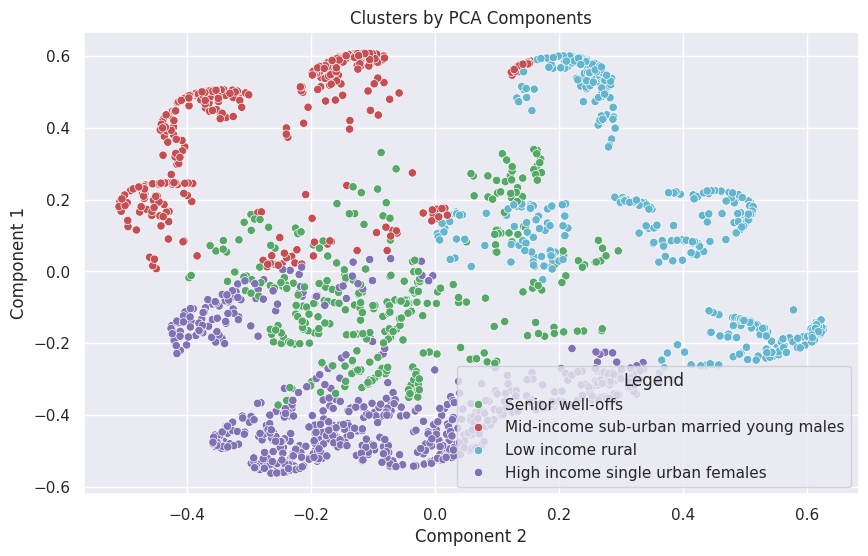

In [41]:
# Plot data by PCA components. For the first one, the Y axis is component 1, X axis is component 2.

x_axis = df_segm_kpca_kmeans['Component 2']
y_axis = df_segm_kpca_kmeans['Component 1']
plt.figure(figsize = (10, 6))
sns.scatterplot(x=x_axis, y=y_axis, hue = df_segm_kpca_kmeans['Legend'], palette = ['g', 'r', 'c', 'm'])
plt.title('Clusters by PCA Components')
plt.show()

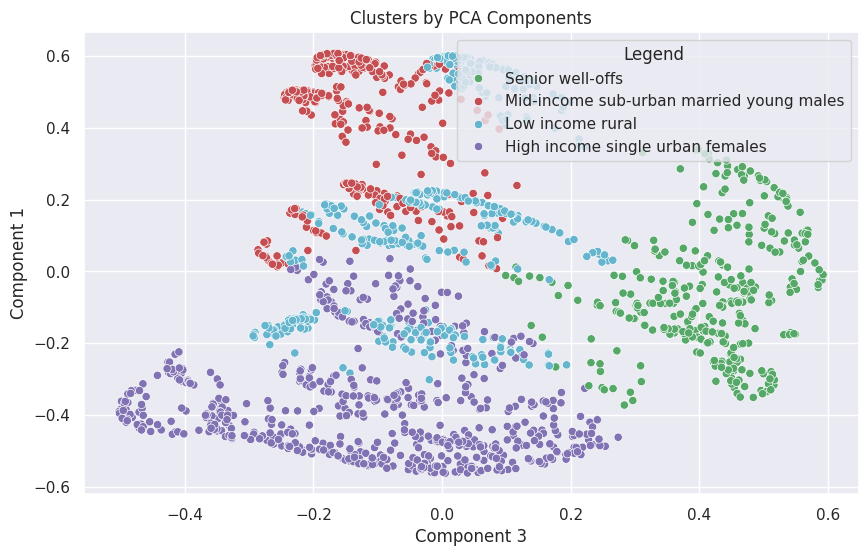

In [43]:
x_axis_1 = df_segm_kpca_kmeans['Component 3']
y_axis_1 = df_segm_kpca_kmeans['Component 1']
plt.figure(figsize = (10,6))
sns.scatterplot(x=x_axis_1, y=y_axis_1, hue = df_segm_kpca_kmeans['Legend'], palette = ['g', 'r', 'c', 'm'])
plt.title('Clusters by PCA Components' )
plt.show()

## **UMAP**

In [49]:
import matplotlib.pyplot as plt
import umap

reducer = umap.UMAP(n_components=3, random_state=42)
scores_umap = reducer.fit_transform(data_scaled)


The optimal number of clusters suggested by the Elbow criterion: 4


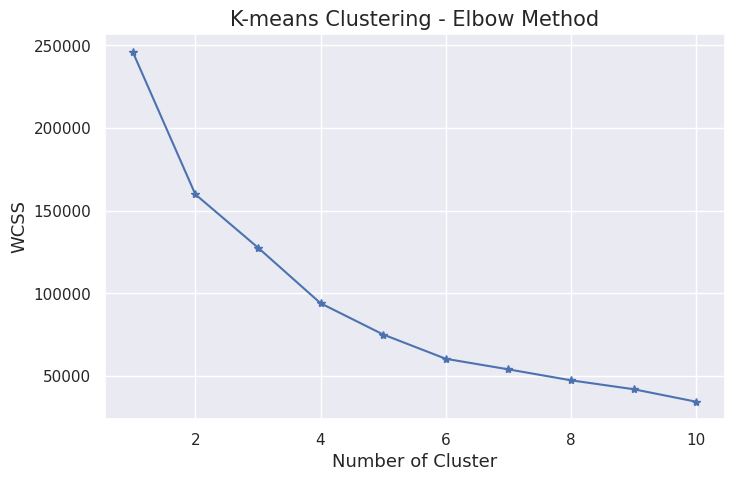

In [50]:
wcss = []
for i in range(1,11):
    kmeans_umap = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans_umap.fit(scores_umap)
    wcss.append(kmeans_umap.inertia_)


# Elbow method
plt.figure(figsize =(8,5))
# Changed this line to plot wcss against the range of cluster numbers
plt.plot(range(1, 11), wcss,  marker = '*', linestyle = '-' )

plt.xlabel('Number of Cluster', fontsize = 13)
plt.ylabel('WCSS', fontsize = 13)
plt.title('K-means Clustering - Elbow Method', fontsize = 15)

# Extract x and y values from WCSS
x, y = range(1, 11), wcss

# Identify the optimal number of clusters using the Elbow method
kn = KneeLocator(x, y, curve="convex", direction="decreasing")

print(f"The optimal number of clusters suggested by the Elbow criterion: {kn.knee}")

In [51]:
kmeans_umap = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
kmeans_umap.fit(scores_umap)

KMeans(n_clusters=4, random_state=42)

In [53]:
# We create a new data frame with the original features and add the PCA scores and assigned clusters.

df_segm_umap_kmeans = pd.concat([df.reset_index(drop = True), pd.DataFrame(scores_umap)], axis = 1)
df_segm_umap_kmeans.columns.values[-3: ] = ['Component 1', 'Component 2', 'Component 3']

# The last column we add contains the pca k-means clustering labels.

df_segm_umap_kmeans['Segment K-means UMAP'] = kmeans_umap.labels_
df_segm_umap_kmeans

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Component 1,Component 2,Component 3,Segment K-means UMAP
0,0,0,67,2,124670,1,2,6.472395,4.375738,7.042585,1
1,1,1,22,1,150773,1,2,-5.487456,9.930034,2.028688,3
2,0,0,49,1,89210,0,0,13.198168,-1.710600,6.744434,0
3,0,0,45,1,171565,1,1,10.515836,-1.752502,16.393318,0
4,0,0,53,1,149031,1,1,10.781126,-1.768794,16.593281,0
...,...,...,...,...,...,...,...,...,...,...,...
1995,1,0,47,1,123525,0,0,1.053190,-7.288799,-0.688377,1
1996,1,1,27,1,117744,1,0,-2.169050,11.875768,8.517821,3
1997,0,0,31,0,86400,0,0,22.633200,4.984349,8.591964,2
1998,1,1,24,1,97968,0,0,-3.854656,6.099895,16.071770,3


In [54]:
# We calculate the means by segments.

df_segm_umap_kmeans_freq = df_segm_umap_kmeans.groupby(['Segment K-means UMAP']).mean()
df_segm_umap_kmeans_freq

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Component 1,Component 2,Component 3
Segment K-means UMAP,,,,,,,,,,
0,0.000000,0.385375,37.144269,1.025692,115303.448617,0.683794,0.598814,8.180296,-0.814420,12.099271
1,0.739479,0.507014,46.018036,1.637275,132509.274549,0.819639,0.665331,2.803663,3.524821,2.386065
2,0.000000,0.000000,33.213333,0.433333,132060.691111,1.128889,1.300000,13.754282,10.246657,7.164416
3,1.000000,1.000000,27.732110,1.000000,106451.108257,0.656881,0.473394,-4.259647,7.696037,10.903730


Summary
**Segment 0**: Mid-life, moderately educated, professional, and moderately affluent individuals (females) focused on specific components (Components 1 and 3).

**Segment 1**: Middle-aged, mainly males, affluent, probably sub-urban professionals with a good balance of education, career, and lifestyle influences (Components 1, 2, and 3).

**Segment 2**: Young, highly educated, affluent, and likely in top management, with a dominant influence from all UMAP components (especially 1 and 2).

**Segment 3**: Young, lower-income, rural individuals (males) with a focus on lifestyle rather than career, with significant contributions from Components 2 and 3

In [55]:
# Calculate the size of each cluster and its proportion to the entire data set.

df_segm_umap_kmeans_freq['N_Obs'] = df_segm_umap_kmeans[['Segment K-means UMAP','Sex']].groupby(['Segment K-means UMAP']).count()
df_segm_umap_kmeans_freq['Prop_Obs'] = df_segm_umap_kmeans_freq['N_Obs'] / df_segm_umap_kmeans_freq['N_Obs'].sum()
df_segm_umap_kmeans_freq = df_segm_umap_kmeans_freq.rename({0:'Mid income single urban females',
                                                          1:'High income senior individuals',
                                                          2:'High Income single urban females',
                                                          3:'Relatively low income rural males'})
df_segm_umap_kmeans_freq

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Component 1,Component 2,Component 3,N_Obs,Prop_Obs
Segment K-means UMAP,,,,,,,,,,,,
Mid income single urban females,0.000000,0.385375,37.144269,1.025692,115303.448617,0.683794,0.598814,8.180296,-0.814420,12.099271,506,0.2530
High income senior individuals,0.739479,0.507014,46.018036,1.637275,132509.274549,0.819639,0.665331,2.803663,3.524821,2.386065,499,0.2495
High Income single urban females,0.000000,0.000000,33.213333,0.433333,132060.691111,1.128889,1.300000,13.754282,10.246657,7.164416,450,0.2250
Relatively low income rural males,1.000000,1.000000,27.732110,1.000000,106451.108257,0.656881,0.473394,-4.259647,7.696037,10.903730,545,0.2725


In [56]:
df_segm_umap_kmeans['Legend'] = df_segm_umap_kmeans['Segment K-means UMAP'].map({0:'Mid income single urban females',
                                                          1:'High income senior individuals',
                                                          2:'High Income single urban females',
                                                          3:'Relatively low income rural males'})

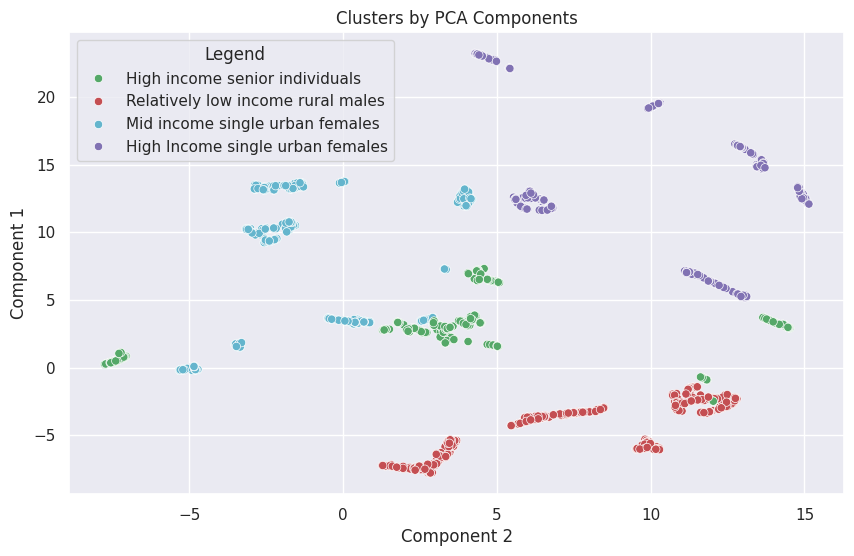

In [57]:
# Plot data by PCA components. For the first one, the Y axis is component 1, X axis is component 2.

x_axis = df_segm_umap_kmeans['Component 2']
y_axis = df_segm_umap_kmeans['Component 1']
plt.figure(figsize = (10, 6))
sns.scatterplot(x=x_axis, y=y_axis, hue = df_segm_umap_kmeans['Legend'], palette = ['g', 'r', 'c', 'm'])
plt.title('Clusters by PCA Components')
plt.show()

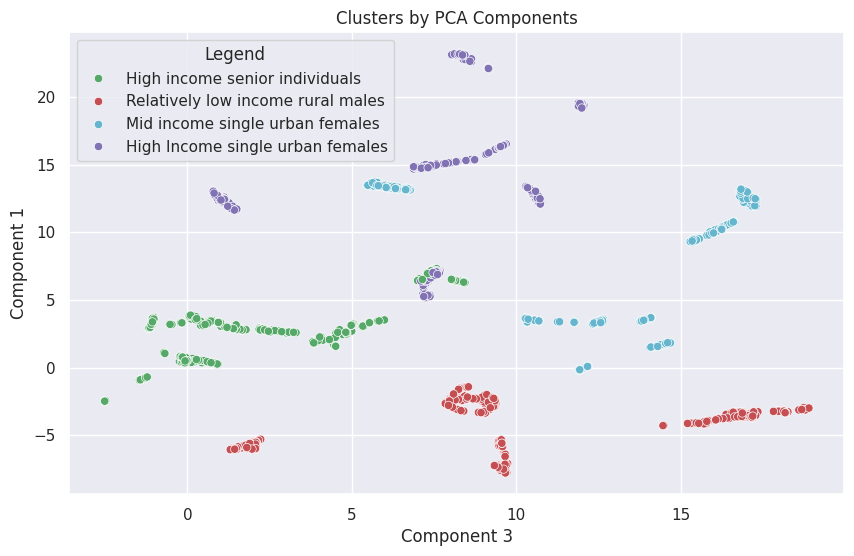

In [58]:
x_axis_1 = df_segm_umap_kmeans['Component 3']
y_axis_1 = df_segm_umap_kmeans['Component 1']
plt.figure(figsize = (10,6))
sns.scatterplot(x=x_axis_1, y=y_axis_1, hue = df_segm_umap_kmeans['Legend'], palette = ['g', 'r', 'c', 'm'])
plt.title('Clusters by PCA Components' )
plt.show()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Component 1,Component 2,Component 3,Segment K-means UMAP,Legend
0,0,0,67,2,124670,1,2,6.472395,4.375738,7.042585,1,High income senior individuals
1,1,1,22,1,150773,1,2,-5.487456,9.930034,2.028688,3,Relatively low income rural males
2,0,0,49,1,89210,0,0,13.198168,-1.710600,6.744434,0,Mid income single urban females
3,0,0,45,1,171565,1,1,10.515836,-1.752502,16.393318,0,Mid income single urban females
4,0,0,53,1,149031,1,1,10.781126,-1.768794,16.593281,0,Mid income single urban females
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1,0,47,1,123525,0,0,1.053190,-7.288799,-0.688377,1,High income senior individuals
1996,1,1,27,1,117744,1,0,-2.169050,11.875768,8.517821,3,Relatively low income rural males
1997,0,0,31,0,86400,0,0,22.633200,4.984349,8.591964,2,High Income single urban females
1998,1,1,24,1,97968,0,0,-3.854656,6.099895,16.071770,3,Relatively low income rural males


In [64]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import numpy as np

def evaluate_clustering(X, labels, method_name, kmeans_model):
    """Evaluate clustering performance using multiple metrics."""

    silhouette = silhouette_score(X, labels)
    davies_bouldin = davies_bouldin_score(X, labels)
    calinski_harabasz = calinski_harabasz_score(X, labels)


    return {
        "method": method_name,
        "silhouette_score": silhouette,
        "davies_bouldin_score": davies_bouldin,
        "calinski_harabasz_score": calinski_harabasz,
    }

# Evaluate all clustering methods
results = [
    evaluate_clustering(scores_pca, kmeans_pca.labels_, "PCA KMeans", kmeans_pca),
    evaluate_clustering(scores_kpca, kmeans_kpca.labels_, "Kernel PCA KMeans", kmeans_kpca),
    evaluate_clustering(scores_umap, kmeans_umap.labels_, "UMAP KMeans", kmeans_umap)
]

# Print results in a structured format
for res in results:
    print(f"{res['method']}:")
    print(f"  - Silhouette Score       = {res['silhouette_score']:.4f}")
    print(f"  - Davies-Bouldin Score   = {res['davies_bouldin_score']:.4f}")
    print(f"  - Calinski-Harabasz Score = {res['calinski_harabasz_score']:.4f}")


PCA KMeans:
  - Silhouette Score       = 0.3374
  - Davies-Bouldin Score   = 1.0280
  - Calinski-Harabasz Score = 950.7517
Kernel PCA KMeans:
  - Silhouette Score       = 0.4025
  - Davies-Bouldin Score   = 0.8691
  - Calinski-Harabasz Score = 1327.9175
UMAP KMeans:
  - Silhouette Score       = 0.3849
  - Davies-Bouldin Score   = 1.0205
  - Calinski-Harabasz Score = 1075.8607


**Silhouette Score**:

Ranges from -1 to 1
Higher values indicate better-defined clusters
Kernel PCA KMeans has the highest score (0.4025), suggesting the best cluster separation
PCA KMeans has the lowest score (0.3374)


**Davies-Bouldin Score**:

Lower values indicate better clustering
Kernel PCA KMeans has the lowest score (0.8691), indicating the most compact and well-separated clusters
PCA and UMAP KMeans have similar, higher scores around 1.02


**Calinski-Harabasz Score**:

Higher values indicate better-defined clusters
Kernel PCA KMeans has the highest score (1327.9175)
PCA KMeans has the lowest score (950.7517)

# Davies-Bouldin and Calinski-Harabasz Indices: A Comprehensive Mathematical Analysis

## Davies-Bouldin Index

The **Davies-Bouldin Index** is a sophisticated clustering evaluation metric that quantifies the similarity between clusters by measuring their internal dispersion relative to their separation.

### Mathematical Formulation

Let's define the key components:
- $D_i$: Average distance between points in cluster $i$ and its centroid
- $d_{ij}$: Distance between centroids of clusters $i$ and $j$
- $k$: Number of clusters

The similarity between clusters is represented by the ratio:

$$R_{ij} = \frac{D_i + D_j}{d_{ij}}$$

The complete Davies-Bouldin Index is calculated as:

$$DB = \frac{1}{k} \sum_{i=1}^{k} \max_{i \neq j} \left\{\frac{D_i + D_j}{d_{ij}}\right\}$$

### Key Characteristics
- **Lower values indicate better clustering**
- Ideal score approaches zero
- Measures both cluster compactness and separation

## Calinski-Harabasz Index

The **Calinski-Harabasz Index**, also known as the Variance Ratio Criterion, evaluates clustering quality by comparing between-cluster dispersion to within-cluster dispersion.

### Mathematical Formulation

Key components:
- $B$: Between-cluster scatter matrix
- $W$: Within-cluster scatter matrix
- $k$: Number of clusters
- $n$: Total number of data points

The index is defined as:

$$CH = \frac{\text{tr}(B)/(k-1)}{\text{tr}(W)/(n-k)}$$

### Key Characteristics
- **Higher values indicate better clustering**
- Measures:
  1. Separation between cluster centroids
  2. Compactness of individual clusters

## Comparative Analysis

| Metric | Interpretation | Ideal Value | Key Focus |
|--------|----------------|-------------|-----------|
| Davies-Bouldin | Lower is better | Close to 0 | Cluster similarity and separation |
| Calinski-Harabasz | Higher is better | Larger values | Variance between and within clusters |

### Practical Considerations
- Use both metrics together for comprehensive clustering evaluation
- Consider additional metrics like Silhouette Score
- Interpretation depends on specific dataset characteristics

## Limitations

### Davies-Bouldin Index
- Less reliable with non-globular clusters
- Assumes clusters are convex and isotropic

### Calinski-Harabasz Index
- Assumes clusters are spherical
- Sensitive to outliers
- Works best with well-defined, similarly-sized clusters


# Kernel PCA and UMAP: Advanced Dimensionality Reduction Techniques

## Kernel PCA (Principal Component Analysis)

### Core Concept
Kernel PCA is a non-linear extension of traditional Principal Component Analysis (PCA) that allows for more complex data transformations by leveraging kernel methods.

### Mathematical Foundation
- Traditional PCA works linearly by finding principal components
- Kernel PCA introduces non-linear transformations through kernel functions

### Key Characteristics
- **Non-linear Dimensionality Reduction**
- Captures complex data structures that linear PCA cannot detect
- Transforms data into a higher-dimensional feature space

### Common Kernel Functions
1. **Radial Basis Function (RBF) Kernel**
   - Most popular kernel
   - Captures local and global non-linear relationships
   - Defined by: $K(x_i, x_j) = \exp(-\gamma \|x_i - x_j\|^2)$

2. **Polynomial Kernel**
   - Captures polynomial relationships
   - $K(x_i, x_j) = (x_i \cdot x_j + c)^d$

3. **Sigmoid Kernel**
   - Useful for neural network-like transformations
   - $K(x_i, x_j) = \tanh(\alpha x_i \cdot x_j + c)$

### Advantages
- Handles non-linear data relationships
- Preserves more complex data structures
- Reduces dimensionality while maintaining intrinsic data characteristics

### Limitations
- Computationally expensive
- Kernel selection can significantly impact results
- Risk of overfitting with complex kernels

## UMAP (Uniform Manifold Approximation and Projection)

### Core Concept
UMAP is a modern dimensionality reduction technique that focuses on preserving both local and global data structures.

### Key Methodological Differences from Other Techniques
- Uses fuzzy topology
- Considers data as a high-dimensional manifold
- Optimizes a fuzzy topological representation

### Mathematical Principles
- Based on Riemannian geometry
- Uses a graph-based approach to dimensionality reduction
- Minimizes the cross-entropy between high and low-dimensional representations

### Computational Process
1. Construct a high-dimensional fuzzy simplicial set
2. Optimize a low-dimensional representation
3. Minimize topological and metric information loss

### Advantages
- Faster than t-SNE
- Preserves more global structure
- Works well with high-dimensional data
- Less computational complexity compared to other non-linear techniques

### Hyperparameters
- `n_neighbors`: Controls local vs. global structure balance
- `min_dist`: Determines point clustering density
- `metric`: Distance measurement method

### Comparison with Other Techniques
- More flexible than t-SNE
- Better global structure preservation
- Faster computational performance

## Comparative Analysis: Kernel PCA vs UMAP

| Characteristic | Kernel PCA | UMAP |
|---------------|------------|------|
| **Non-linearity** | Kernel-dependent | Inherently non-linear |
| **Computational Complexity** | High | Moderate |
| **Global Structure Preservation** | Moderate | Excellent |
| **Local Structure Preservation** | Good | Very Good |
| **Scalability** | Limited | High |

### When to Use
- **Kernel PCA**:
  1. Small to medium datasets
  2. Need for specific kernel transformations
  3. Detailed feature space exploration

- **UMAP**:
  1. Large, high-dimensional datasets
  2. Quick visualization needed
  3. Preserving global and local structures